# Data Science Resource Recommendations + Topic Modeling

In this notebook, we're going to walk through the process of building the model to be used for our data science resource recommendation tool.  In addition we do a little topic modeling to get to know our corpus on a more personal level.

The goal of this project was to take a block of text (say, for example, a chapter from the Deep Learning Book) and find blog posts that may be complementary to the materials in that text.  One might see this becoming a useful tool for data scientists and students who want to see multiple perspectives on a subject, or get ideas of what to study next.

In [1]:
from pymongo import MongoClient
from dsresources.dsresources import read_posts

import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction


We're going to want to tokenize and stem the words in our text so let's set up a few helper functions.

In [2]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

In [3]:
def tokenize_and_stem(text):
    """
    Use nltk's tokenizers and snowball stemmer to tokenize and stem all words in a block of text
    """
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [4]:
def tokenize_only(text):
    """
    Use nltk's tokenizers to tokenize all words (but not stem) in a block of text
    """
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

## Build Text Corpus

Our text is loaded in a MongoDB database, so we'll want to access this.

In [11]:
client = MongoClient(port=12345)

In [12]:
db = client.fletcher

In [13]:
test_posts = db.get_collection('test_posts')

One problem I initially had was that some blog posts in my database were in a foreign language and others were corrupted with ASCII characters and such, so I wrote a function to filter these out.  I also filtered out posts that were less than 200 words as these were largely image-only posts or promotions.

In [16]:
import enchant
def is_english(text):
    """
    Returns text that contains at least 70% English words.
    """
    d = enchant.Dict("en_US")
    bad = 0
    good = 0
    for word in tokenize_only(text):
        if d.check(word):
            good += 1
        else:
            bad += 1
    per = (bad/(good+bad))
    if per < .70:
        return True
    else:
        return False

In [17]:
post_texts = [post['text'] for post in test_posts.find() if post['text'] and len(post['text'].split()) > 200 and is_english(post['text'])]

In [18]:
post_titles = [post['title'] for post in test_posts.find() if post['text'] and len(post['text'].split()) > 200 and is_english(post['text'])]

In [19]:
post_urls = [post['url'] for post in test_posts.find() if post['text'] and len(post['text'].split()) > 200 and is_english(post['text'])]

A quick sanity check to ensure the post data lines up.

In [20]:
(len(post_texts), len(post_titles), len(post_urls))

(3963, 3963, 3963)

Let's take a look at a sample.

In [23]:
post_titles[0]

'Scalable Software and Big Data Architecture - Software Architectural Patterns and Design Patterns'

In [30]:
post_texts[0][:240]

'## Articles\n\n  1. Application Types, Requirements, and Components\n  2. Software Architectural Patterns and Design Patterns\n  3. Big Data and Analytics Architectural Patterns (Coming soon)\n\n## Introduction\n\nWelcome to the second article in a'

In [31]:
post_urls[0]

'http://www.innoarchitech.com/scalable-cloud-software-big-data-architecture-architectural-design-patterns/'

We need to remove some common words, as well as some words that may carry some inappropriate weight.

In [32]:
stopwords = nltk.corpus.stopwords.words('english')

In [33]:
stopwords.extend(['machine', 'data', 'science', 'scientist', 'like', '’s', "'s", 'we’ll', 'e', 'g', 'n', 'com', 'el', 'la', 'un', 'los', 'daniel',
                      'tim', 'de', 'en', 'gt', 'lt', 'et', 'posted', 'powered', 'click', 'age', 'style', 'al''video', 'university', 'x', 'https', 'nginx', 'forbidden',
                      'amp', '\theta', 'q', '\mathbb', '\right', '\log', '\left', 'w', '\mathcal', '\hat', 'k', 'l', '\lambda',
                      'year', 'would', "n't", 'post', 'see', 'new', 'look', 'day', 'number', 'thing', 'think', 'want', 'show',
                      'word', 'paper', 'know', '\frac'])
                  
                  
                  
                  

Now we build our vocabulary.

In [34]:
total_vocab_stemmed = []
total_vocab_tokenized = []
for i in post_texts:
    allwords_stemmed = tokenize_and_stem(i)
    total_vocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    total_vocab_tokenized.extend(allwords_tokenized)

In [35]:
len(total_vocab_stemmed), len(total_vocab_tokenized)

(4556441, 4556441)

In [36]:
vocab_frame = pd.DataFrame({'words': total_vocab_tokenized}, index = total_vocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 4556441 items in vocab_frame


## TF-IDF Vectorizer

In this section, we use scikit-learn's TF-IDF Vectorizer to build a matrix of important vocabulary for our corpus.

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.65,
                                   min_df=10, stop_words=stopwords,
                                   use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1, 3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(post_texts)
print(tfidf_matrix.shape)

CPU times: user 2min 55s, sys: 3.57 s, total: 2min 58s
Wall time: 3min 4s
(3963, 25859)


In [38]:
tfidf_fit = tfidf_vectorizer.fit(post_texts)

In [39]:
terms = tfidf_vectorizer.get_feature_names()

In [40]:
tfidf_vectorizer.vocabulary_;

In [41]:
idf = tfidf_vectorizer.idf_
idf_dict = dict(zip(tfidf_vectorizer.get_feature_names(), idf))

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

Here we just pickle some important builds so that we need not rebuild them in the future.

In [12]:
from sklearn.externals import joblib

In [101]:
joblib.dump(tfidf_matrix, 'tfidf_matrix.pkl')

['tfidf_matrix.pkl']

In [100]:
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [103]:
joblib.dump(tfidf_fit, 'tfidf_fit.pkl')

['tfidf_fit.pkl']

In [13]:
joblib.dump(post_titles, 'post_titles.pkl')

['post_titles.pkl']

In [15]:
joblib.dump(post_urls, 'post_urls.pkl')

['post_urls.pkl']

In [ ]:
tfidf_matrix = joblib.load('app/tfidf_matrix.pkl')

## Deep Learning Book Chapter Post Recommendations

We start having some fun in this section by exploring a basic recommedation based on cosine similarity between a new block of text and our TF-IDF matrix.  The hope is that we find blog posts semantically similar to the text in question.  For this example, I pasted a chapter from the Deep Learning Book to see what kind of posts might complement my studies.

In [43]:
pairwise_similarity = tfidf_matrix * tfidf_matrix.T

In [51]:
type(pairwise_similarity)

scipy.sparse.csr.csr_matrix

In [44]:
a = pairwise_similarity.A[-7]

In [46]:
a

array([ 0.0982661 ,  0.14260383,  0.13028344, ...,  0.47294373,
        0.25165604,  0.27551203])

In [47]:
a.argsort()[-10:][::-1]

array([3956, 3959, 3960, 2453, 3955, 2219, 3866,  256, 2503,   88])

Above we can see a bit of what's going on here.  First we compute a dot product of our matrix, which gives us a sparse matrix of similarity scores between posts in our corpus.  Then, we convert this to a numpy array and take an example row for illustrative purposes. This gives us our similarity score for each item in the corpus.  We argsort it to get the most similar. 

Now we repeat this process using a few chapters from the Deep Learning Book.

In [54]:
post_titles[3955]

'Deep Learning Book 6 - Deep Feedforward Networks'

In [57]:
for i in range(1, 9):
    l = []
    a = pairwise_similarity.A[-i]
    sim = a.argsort()[-20:][::-1]
    print('***' + str(post_titles[sim[0]]) + '***')
    while len(l) < 10:
        for post in sim:
            if post_titles[post][0:18] != 'Deep Learning Book':
                l.append(post_titles[post])
    for post in l:
        print(post)
    print('\n')

***Deep Learning Book 10 - Sequence Modeling: Recurrent and Recursive Nets***
The Unreasonable Effectiveness of Recurrent Neural Networks
Understanding LSTM Networks
Deep Learning Research Review Week 3&#58 Natural Language Processing
Written Memories: Understanding, Deriving and Extending the LSTM
Hyper Networks
RNNs in Tensorflow, a Practical Guide and Undocumented Features
Recurrent Neural Network Tutorial, Part 4 – Implementing a GRU/LSTM RNN with Python and Theano
A 'Brief' History of Neural Nets and Deep Learning, Part 3
Gradient descent learns linear dynamical systems
25 Must Know Terms & concepts for Beginners in Deep Learning
LSTMs
Recurrent Neural Networks Tutorial, Part 3 – Backpropagation Through Time and Vanishing Gradients
A Gentle Introduction to Artificial Neural Networks
Rolling and Unrolling RNNs
Attention and Memory in Deep Learning and NLP


***Deep Learning Book 9 - Convolutional Networks***
Understanding Convolution in Deep Learning
Visualizing Features from a Con

***Not too shabby!***

## Clustering

For some bonus fun, in the following sections we're going to cluster the posts in our corpus and find out what are the important topics among the clusters.  We accomplish this with a simple KMeans clustering on our matrix.  Perhaps an extension would be to use hierarchical clustering or an alternative such as DBScan.

In [58]:
from sklearn.cluster import KMeans
num_clusters = 10
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 4min 4s, sys: 4.02 s, total: 4min 8s
Wall time: 4min 15s


In [59]:
posts = { 'title': post_titles, 'text': post_texts, 'cluster': clusters, 'url': post_urls }

df = pd.DataFrame(posts, index = [clusters] , columns = ['title', 'cluster', 'url'])


In [60]:
df.head()

,title,cluster,url
7,Scalable Software and Big Data Architecture - ...,7,http://www.innoarchitech.com/scalable-cloud-so...
8,"What Is Data Science, and What Does a Data Sci...",8,http://www.innoarchitech.com/what-is-data-scie...
7,Scalable Software and Big Data Architecture - ...,7,http://www.innoarchitech.com/cloud-software-bi...
2,IndyCar - a Technical and Not So Technical Ove...,2,http://www.innoarchitech.com/indycar-champcar-...
7,How to Choose the Right Database System: RDBMS...,7,http://www.innoarchitech.com/how-choose-right-...


In [61]:
df['cluster'].value_counts()

2    1122
5     634
4     391
0     354
7     297
3     266
8     258
6     231
9     214
1     196
Name: cluster, dtype: int64

In [62]:
print("Top terms per cluster:")
print()

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :20]:
        if len(terms[ind].split()) > 1:
            a = vocab_frame.ix[terms[ind].split()[0]]['words'].iloc[0]
            b = vocab_frame.ix[terms[ind].split()[1]]['words'].iloc[0]
            print(a + ' ' + b)
        else:
            print(vocab_frame.ix[terms[ind]]['words'].iloc[0])
    print()
    print()
    
    print("Cluster %d titles:" % i, end='')
    for title in df.ix[i]['title'].values.tolist()[:5]:
        print(' %s,' % title, end='')
    print()
    print()
    
print()
print()

Top terms per cluster:

Cluster 0 words:files
install
python
code
package
r
running
command
scripts
created
notebooks
line
needed
spark
functionality
testing
important
work
library’s
users


Cluster 0 titles: Create Audiobooks with Amazon Polly and AWS Batch, Managing managed libraries with Scala and Eclipse, Render reports directly from R scripts, Blogging with Jekyll and R Markdown using knitr, DIY building an R package,

Cluster 1 words:network
layers
image
training
neural
models
neural network
inputs
vectorizer
output
gradient
learning
weighting
convolutional
neurons
functionality
deep
losses
generate
features


Cluster 1 titles: Artificial Neural Networks Introduction (Part II), Artificial Neural Networks (ANN) Introduction, ICML 2013 Reading List, ICML 2012 Deep Learning and Unsupervised Feature Extraction Reading List, Paper Notes: The Shattered Gradients Problem ...,

Cluster 2 words:people
work
get
team
research
point
interest
because
book
review
different
learning
talk
player

## Build Word Clouds

In [63]:
from PIL import Image
from os import path
import cv2
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
def build_cluster_cloud(order_centroids, cluster, num_words=200, mask_image=None, bg_color='#000'):
    # Build list of words
    cluster_list = []
    val = num_words
    for ind in order_centroids[cluster, :num_words]:
        if len(terms[ind].split()) > 1:
            a = vocab_frame.ix[terms[ind].split()[0]]['words'].iloc[0]
            b = vocab_frame.ix[terms[ind].split()[1]]['words'].iloc[0]
            cluster_list.append((str(a + ' ' + b), val))
        else:
            cluster_list.append((vocab_frame.ix[terms[ind]]['words'].iloc[0], val))
        val -= 1
        
    # Build Word Cloud
    if mask_image:
        mask = np.array(Image.open(open(mask_image, 'rb')))
        wc = WordCloud(mask=mask, background_color=bg_color).generate_from_frequencies(cluster_list)
    else:
        wc = WordCloud().generate_from_frequencies(cluster_list)
    #wc = WordCloud(mask=mask).generate(''.join(tfidf_vectorizer.vocabulary_.keys()))
    plt.figure(figsize=(12, 10))
    plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return

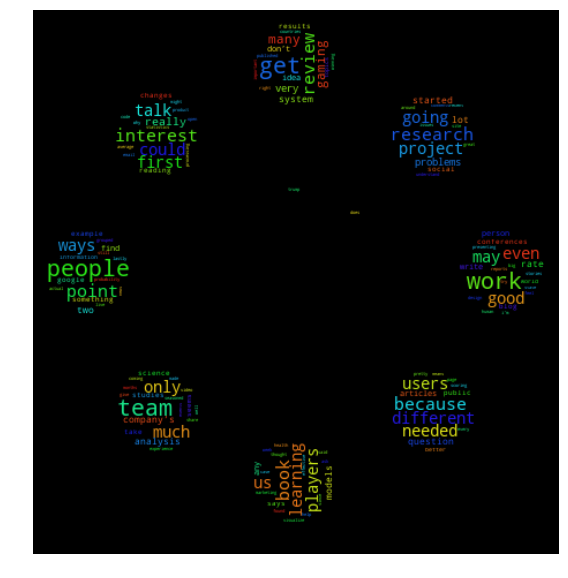

In [65]:
build_cluster_cloud(order_centroids, 2, mask_image='graph.png')

In [75]:
cluster_list = []
val = 200
for ind in order_centroids[6, :200]:
    if len(terms[ind].split()) > 1:
        a = vocab_frame.ix[terms[ind].split()[0]]['words'].iloc[0]
        b = vocab_frame.ix[terms[ind].split()[1]]['words'].iloc[0]
        cluster_list.append((str(a + ' ' + b), val))
    else:
        cluster_list.append((vocab_frame.ix[terms[ind]]['words'].iloc[0], val))
    #cluster_list.append(('%s' % vocab_frame.ix[terms[ind].split(' ')].index[0], val))
    val -= 1
    

In [76]:
cluster_list

[('learning', 200),
 ('deep', 199),
 ('ai', 198),
 ('deep learning', 197),
 ('machine', 196),
 ('machine learning', 195),
 ('intelligence', 194),
 ('models', 193),
 ('neural', 192),
 ('network', 191),
 ('research', 190),
 ('computers', 189),
 ('system', 188),
 ('algorithms', 187),
 ('human', 186),
 ('artificial', 185),
 ('neural network', 184),
 ('artificial intelligence', 183),
 ('image', 182),
 ('training', 181),
 ('robotics', 180),
 ('vision', 179),
 ('video', 178),
 ('work', 177),
 ('google', 176),
 ('problems', 175),
 ('technology', 174),
 ('computers vision', 173),
 ('reinforce learning', 172),
 ('reinforce', 171),
 ('development', 170),
 ('processing', 169),
 ('prediction', 168),
 ('very', 167),
 ('many', 166),
 ('understand', 165),
 ('company’s', 164),
 ('recognition', 163),
 ('build', 162),
 ('science', 161),
 ('needed', 160),
 ('going', 159),
 ('get', 158),
 ('application', 157),
 ('approaches', 156),
 ('gaming', 155),
 ('brain', 154),
 ('language', 153),
 ('different', 152),

In [77]:
mask = np.array(Image.open(open('robot_bw.png', 'rb')))
img = np.array(Image.open("robot.jpg"))

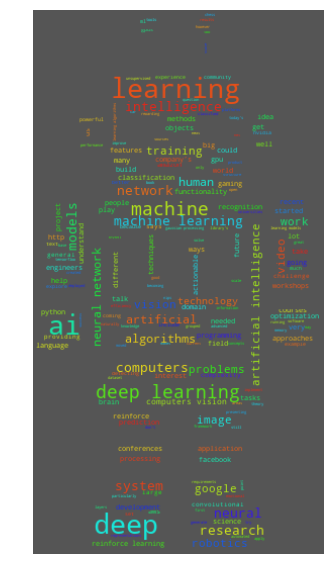

In [80]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wc = WordCloud(mask=mask, background_color="#555").generate_from_frequencies(cluster_list)
#wc = WordCloud(mask=mask).generate(''.join(tfidf_vectorizer.vocabulary_.keys()))
plt.figure(figsize=(12, 10))
plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()